In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (roc_auc_score, average_precision_score,
                           roc_curve, precision_recall_curve,
                           confusion_matrix, classification_report)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import anndata as ad
ppmi_ad = ad.read_h5ad("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/ppmi_adata.h5ad")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.

In [3]:
consensus_genes = pd.read_csv("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/feature_selection_intersection_consensus_males_30-50.csv", index_col=0)

In [4]:
mask = ((ppmi_ad.obs['Age_Group'] == '30-50') &
        (ppmi_ad.obs['Gender'] == 'Male') &
        (ppmi_ad.obs['Diagnosis'].isin(['PD', 'Control'])) &
        (ppmi_ad.obs['Visit'] == 'BL'))

In [5]:
ppmi_ad = ppmi_ad[mask]

In [6]:
ppmi_ad = ppmi_ad[:, ppmi_ad.var.index.isin(consensus_genes.index)]


/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_1827/3785693463.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


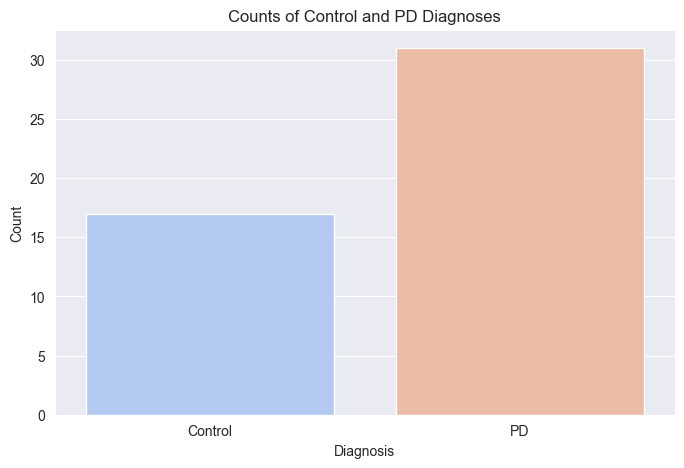

In [58]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=ppmi_ad.obs,
    x='Diagnosis',
    palette='coolwarm'
)
plt.title('Counts of Control and PD Diagnoses')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

In [30]:
X = pd.DataFrame(ppmi_ad.layers['counts_log2'], columns=ppmi_ad.var_names)
y = (ppmi_ad.obs['Diagnosis'] == 'PD').astype(int)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [48]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'lr__C': np.logspace(-3, 3, 7),
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear'],
    'smote__k_neighbors': [3, 5]
}

grid_search = GridSearchCV(
    lr_pipeline,
    param_grid,
    cv=StratifiedKFold(10),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
best_lr = grid_search.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


In [50]:
best_lr.named_steps['lr'].get_params()

{'C': np.float64(0.1),
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [51]:
best_lr.fit(X_train, y_train)
y_pred = best_lr.predict(X_test)
y_proba = best_lr.predict_proba(X_test)[:,1]

In [52]:
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.80      0.67      0.73         6

    accuracy                           0.70        10
   macro avg       0.70      0.71      0.70        10
weighted avg       0.72      0.70      0.70        10



In [53]:
print(f"\nROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"PR-AUC: {average_precision_score(y_test, y_proba):.3f}")


ROC-AUC: 0.792
PR-AUC: 0.883


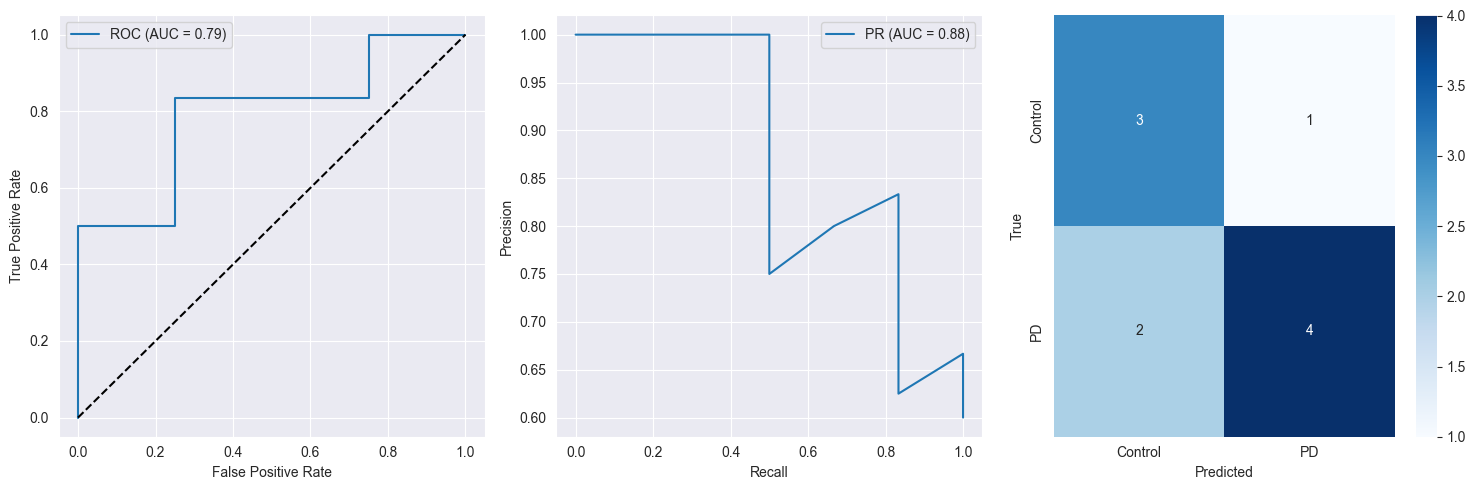

In [54]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
fpr, tpr, roc_threshold = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot(1, 3, 2)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, label=f'PR (AUC = {average_precision_score(y_test, y_proba):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Control', 'PD'],
            yticklabels=['Control', 'PD'])
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

In [55]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = {'roc_auc': [], 'pr_auc': []}

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lr_pipeline.fit(X_train, y_train)
    y_proba = lr_pipeline.predict_proba(X_val)[:, 1]

    cv_scores['roc_auc'].append(roc_auc_score(y_val, y_proba))
    cv_scores['pr_auc'].append(average_precision_score(y_val, y_proba))

print("\nCross-validation results:")
print(f"ROC-AUC: {np.mean(cv_scores['roc_auc']):.3f} ± {np.std(cv_scores['roc_auc']):.3f}")
print(f"PR-AUC: {np.mean(cv_scores['pr_auc']):.3f} ± {np.std(cv_scores['pr_auc']):.3f}")



Cross-validation results:
ROC-AUC: 0.917 ± 0.171
PR-AUC: 0.944 ± 0.117


In [56]:
coefficients = pd.DataFrame({
    'ensembl_id': consensus_genes.index,
    'gene_symbol': consensus_genes['gene_symbol'],
    'coefficient': lr_pipeline.named_steps['lr'].coef_[0],
    'abs_coef': np.abs(lr_pipeline.named_steps['lr'].coef_[0])
}).sort_values('abs_coef', ascending=False)

print("\nTop 40 predictive genes:")
print(coefficients.head(40)[['gene_symbol', 'coefficient']])


Top 40 predictive genes:
                        gene_symbol  coefficient
ENSG00000253153.1      LOC124901995    -0.103400
ENSG00000187689.9              AMTN    -0.098739
ENSG00000244756.1           RPL37P5    -0.089060
ENSG00000177855.8          CACYBPP2    -0.086929
ENSG00000164062.12             APEH    -0.085423
ENSG00000253945.1   ENSG00000253945    -0.079889
ENSG00000251987.1           SNORD63    -0.078174
ENSG00000175550.7             DRAP1    -0.076467
ENSG00000226722.3         LINC00424    -0.074540
ENSG00000254863.1         LINC02744    -0.072553
ENSG00000282358.1   ENSG00000282358    -0.072147
ENSG00000224478.2      LOC124901449     0.070953
ENSG00000154814.13           OXNAD1    -0.070439
ENSG00000131459.12            GFPT2    -0.069582
ENSG00000138669.9             PRKG2    -0.069521
ENSG00000140057.8               AK7     0.069140
ENSG00000279182.1   ENSG00000279182    -0.068790
ENSG00000149656.8   ENSG00000149656    -0.068671
ENSG00000234772.1         LINC00412     0.0

/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_1827/888752835.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


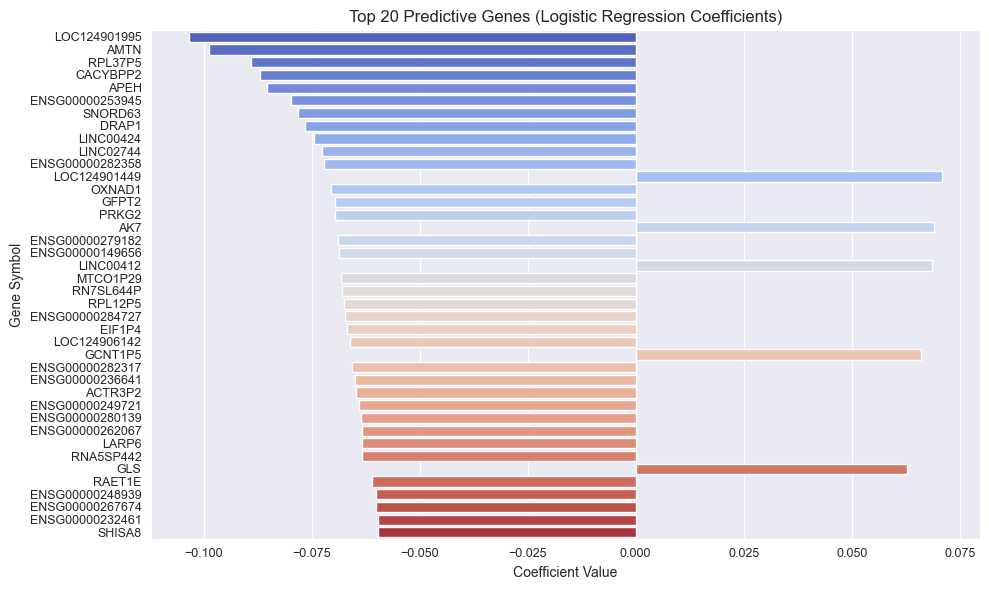

In [57]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=coefficients.head(40),
    x='coefficient',
    y='gene_symbol',
    palette='coolwarm'
)
plt.title('Top 20 Predictive Genes (Logistic Regression Coefficients)')
plt.xlabel('Coefficient Value')
plt.ylabel('Gene Symbol')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

### Precision-Recall Tradeoff (best for imbalanced data)

In [42]:
optimal_idx = np.argmax(precision * recall)
optimal_threshold_pr = thresholds[optimal_idx]
print(f"Optimal PR Threshold: {optimal_threshold_pr:.3f}")

Optimal PR Threshold: 0.360


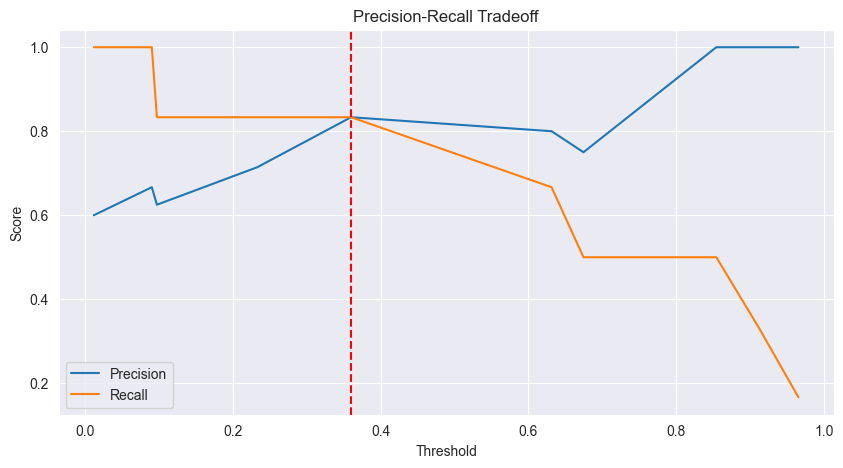

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(optimal_threshold_pr, color='r', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Tradeoff')
plt.legend()
plt.show()

In [44]:
final_threshold = optimal_threshold_pr
y_pred_custom = (y_proba >= final_threshold).astype(int)
print(classification_report(y_test, y_pred_custom))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

ValueError: Found input variables with inconsistent numbers of samples: [10, 4]

In [45]:
y_pred_custom

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 1])

In [46]:
y_proba

array([9.99948294e-01, 2.69027376e-02, 9.99935072e-01, 2.15013449e-07,
       7.28956514e-05, 1.59122278e-02, 9.99961485e-01, 9.99939536e-01,
       5.06101700e-08, 9.99944119e-01])